In [30]:
from __future__ import annotations

import os
import tempfile
from typing import Annotated, Any, Dict, Optional, TypedDict
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.vectorstores import FAISS
from langchain_core.messages import BaseMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver

In [31]:
from app.config import Config
llm = ChatGroq(
        model_name="llama-3.3-70b-versatile",
        api_key=Config.qroq_api_key,
        )

In [44]:
search_tool = DuckDuckGoSearchRun(region="us-en")

In [55]:
file_path = "../data/attention_is_all_you_need_Paper.pdf"
loader = PyPDFLoader(file_path)
documents= loader.load()
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


In [56]:
def process_documents(documents):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
    )
    docs = text_splitter.split_documents(documents)
    
    return docs

docs=process_documents(documents)

vector_Store= FAISS.from_documents(docs, embeddings)





In [65]:
retriever = vector_Store.as_retriever(search_kwargs={"k": 3})
retriever.invoke("what is attention")

[Document(id='8c068b8e-c530-410f-b253-84719302506e', metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'subject': 'Neural Information Processing Systems http://nips.cc/', 'publisher': 'Curran Associates, Inc.', 'language': 'en-US', 'created': '2017', 'eventtype': 'Poster', 'description-abstract': 'The dominant sequence transduction models are based on complex recurrent orconvolutional neural networks in an encoder and decoder configuration. The best performing such models also connect the encoder and decoder through an attentionm echanisms.  We propose a novel, simple network architecture based solely onan attention mechanism, dispensing with recurrence and convolutions entirely.Experiments on two machine translation tasks show these models to be superiorin quality while being more parallelizable and requiring significantly less timeto train. Our single model with 165 million parameters, achieves 27.5 BLEU onEnglish-to-German translation, improving over the existi

In [71]:
@tool
def rag_tool(query: str,retriever) -> dict:
    """
    Retrieve relevant information from the uploaded PDF document.
   
    """
    retriever =retriever
    if retriever is None:
        return {
            "error": "No document indexed for this chat. Upload a PDF first.",
            "query": query,
        }

    result = retriever.invoke(query)
    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        "query": query,
        "context": context,
        "metadata": metadata,
    }



In [ ]:
rag_tool("what is attention",retriever)

{'query': 'what is attention',
 'context': ['convolution is equal to the combination of a self-attention layer and a point-wise feed-forward layer,\nthe approach we take in our model.\nAs side beneﬁt, self-attention could yield more interpretable models. We inspect attention distributions\nfrom our models and present and discuss examples in the appendix. Not only do individual attention\nheads clearly learn to perform different tasks, many appear to exhibit behavior related to the syntactic\nand semantic structure of the sentences.\n5 Training\nThis section describes the training regime for our models.\n5.1 Training Data and Batching\nWe trained on the standard WMT 2014 English-German dataset consisting of about 4.5 million\nsentence pairs. Sentences were encoded using byte-pair encoding [ 3], which has a shared source-\ntarget vocabulary of about 37000 tokens. For English-French, we used the signiﬁcantly larger WMT\n2014 English-French dataset consisting of 36M sentences and split tok

In [72]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [73]:
tools = [rag_tool, search_tool]
llm_with_tools = llm.bind_tools(tools)

In [74]:
def chat_node(state: ChatState, config=None):
    """LLM node that may answer or request a tool call."""

    system_message = SystemMessage(
        content=(
            "You are a helpful assistant. For questions about the uploaded PDF, call "
            "the `rag_tool` . You can also use the web search tool when helpful. "
            "If no document is available, ask the user "
            "to upload a PDF."
        )
    )
    

    messages = [system_message, *state["messages"]]
    response = llm_with_tools.invoke(messages, config=config)
    return {"messages": [response]}


In [75]:
tool_node = ToolNode(tools)

In [76]:
checkpointer = InMemorySaver()

graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node", tools_condition)
graph.add_edge("tools", "chat_node")

chatbot = graph.compile(checkpointer=checkpointer)

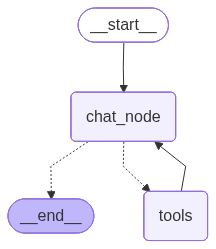

In [77]:
chatbot

In [84]:
from langchain_core.messages import HumanMessage
CONFIG = {'configurable': {'thread_id': 'thread-1'}}
response=chatbot.invoke({"messages": [HumanMessage(content="whats my name")]}, config=CONFIG)

In [85]:
response

{'messages': [HumanMessage(content='what is attemtion is all you need?', additional_kwargs={}, response_metadata={}, id='ef5715c4-54a4-47ff-85ea-86f38cdeb684'),
  HumanMessage(content='hi i m raaj', additional_kwargs={}, response_metadata={}, id='b6f40f9d-a09f-4ca6-814d-23a570c84019'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '1atdr3qc9', 'function': {'arguments': '{"query":"Attention Is All You Need"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 396, 'total_tokens': 417, 'completion_time': 0.062664661, 'completion_tokens_details': None, 'prompt_time': 0.020438461, 'prompt_tokens_details': None, 'queue_time': 0.057012999, 'total_time': 0.083103122}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_dae98b5ecb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--246e4b0a-ce61-4806-aac2-0490659fce

In [ ]:
from typing import Annotated, TypedDict, List, Dict, Any
from langchain_core.messages import BaseMessage, SystemMessage
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver
from langchain_community.tools import DuckDuckGoSearchRun
from typing import Annotated, TypedDict, List, Dict, Any, Optional, Callable
from langchain_core.messages import BaseMessage, SystemMessage
from langchain_core.tools import tool as tool_decorator
from app.config import Config
from app.logger import logging


def rag_tool_impl(retriever: Any, query: str) -> Dict[str, Any]:
    """Pure function implementing the RAG logic (no @tool decoration)."""
    if retriever is None:
        return {
            "error": "No document indexed for this chat. Upload a PDF first.",
            "query": query,
        }

    try:
        results = retriever.get_relevant_documents(query)
    except AttributeError:
        try:
            results = retriever.invoke(query)
        except Exception as e:
            logging.exception("Retriever invocation failed: %s", e)
            return {"error": "Retriever invocation failed.", "detail": str(e)}
    except Exception as e:
        logging.exception("Retriever failed: %s", e)
        return {"error": "Retriever failed.", "detail": str(e)}

    context = [getattr(doc, "page_content", str(doc)) for doc in results]
    metadata = [getattr(doc, "metadata", {}) for doc in results]

    return {"query": query, "context": context, "metadata": metadata}


class LLmService:
    class chatState(TypedDict):
        messages: Annotated[list[BaseMessage], add_messages]

    def __init__(self, vector_store, query: str):
        logging.info("Initializing LLM Service.")
        self.query = query
        self.vector_store = vector_store

        # initialize LLM
        self.llm = ChatGroq(
            model_name="llama-3.3-70b-versatile",
            api_key=Config.qroq_api_key,
        )

        # Retriever (if available)
        self.retriever = None
        try:
            if vector_store and hasattr(vector_store, "vector_store"):
                self.retriever = vector_store.vector_store.as_retriever(
                    search_type="similarity", search_kwargs={"k": 4}
                )
        except Exception as e:
            logging.exception("Failed to create retriever from vector_store: %s", e)
            self.retriever = None

        # Tools: web search and RAG tool (rag_tool is instance method)
        self.search_tool = DuckDuckGoSearchRun(region="us-en")

        def _rag_closure(tool_input: Optional[Dict[str, Any]] = None) -> Dict[str, Any]:
            """RAG tool: return nearest documents for the current query using the provided retriever."""
            return rag_tool_impl(self.retriever, self.query)

       
        self.rag_tool = tool_decorator(_rag_closure)

        # Now the tools list contains tool objects (not the result of calling them).
        self.tools = [self.rag_tool, self.search_tool]

        # Bind tools to the LLM (safe)
        self.llm_with_tools = self.llm.bind_tools(self.tools)

        # Build LangGraph nodes and graph in __init__
        self.tool_node = ToolNode(self.tools)

        self.checkpointer = InMemorySaver()
        
        self.graph = StateGraph(self.chatState)
        self.graph.add_node("chat_node", self.chat_node)
        self.graph.add_node("tools", self.tool_node)
        
        self.graph.add_edge(START, "chat_node")
        self.graph.add_conditional_edges("chat_node", tools_condition)
        self.graph.add_edge("tools", "chat_node")
        
        self.chatbot = self.graph.compile(checkpointer=self.checkpointer)

    # RAG tool implemented as an instance method; decorated with @tool


    def chat_node(self, state: chatState, config=None) -> Dict[str, List[BaseMessage]]:
        """LLM node that may answer or request a tool call."""
        system_message = SystemMessage(
            content=(
                "You are a helpful assistant. For questions about the uploaded PDF, call "
                "the `rag_tool`. You can also use the web search tool when helpful. "
                "If no document is available, ask the user to upload a PDF."
            )
        )

        messages = [system_message, *state["messages"]]
        try:
            # llm_with_tools is bound LLM that can call tools
            response = self.llm_with_tools.invoke(messages, config=config)
        except Exception as e:
            logging.exception("LLM invocation failed: %s", e)
            # Return an error message wrapped as a system message (or format as your app expects)
            return {"messages": [SystemMessage(content=f"LLM invocation error: {e}")]}

        return {"messages": [response]}

    # Optionally expose a convenience run method to call the compiled chatbot
    def run(self, initial_messages: List[BaseMessage]):
        # The graph expects a specific state format; adapt as necessary
        CONFIG = {'configurable': {'thread_id': 'thread-1'}}
        state: LLmService.chatState = {"messages": initial_messages}
        return self.chatbot.invoke(state,config=CONFIG)


In [ ]:
from typing import Annotated, TypedDict, List, Dict, Any
from langchain_core.messages import BaseMessage, SystemMessage
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver
from langchain_community.tools import DuckDuckGoSearchRun
from typing import Annotated, TypedDict, List, Dict, Any, Optional, Callable
from langchain_core.messages import BaseMessage, SystemMessage
from langchain_core.tools import tool
from app.vector_store.vector_store import VectorStore
from app.config import Config
from app.logger import logging



class ChatState(TypedDict):
        messages: Annotated[list[BaseMessage], add_messages]

llm = ChatGroq(
        model_name="llama-3.3-70b-versatile",
        api_key=Config.qroq_api_key,
        )

vector_store=VectorStore()



def chat_node(state: ChatState, config=None):
    """LLM node that may answer or request a tool call."""
    thread_id = "thread_1"
    system_message = SystemMessage(
        content=(
            "You are a helpful assistant. For questions about the uploaded PDF, call "
            "the `rag_tool` and include the thread_id "
            f"`{thread_id}`."
            "If no document is available, ask the user "
            "to upload a PDF."
        )
    )
    messages = [system_message, *state["messages"]]
    response = llm_with_tools.invoke(messages, config=config)
    return {"messages": [response]}

@tool
def rag_tool(query: str) -> dict:
    """
    Retrieve relevant information from the uploaded PDF(s).
    """
    # ensure vectorstore has been initialized and loaded
    if vector_store.vector_store is None:
        return {
            "error": "No document indexed for this chat. Upload a PDF first.",
            "query": query,
        }

    # Use the retriever interface if available, else fallback to similarity_search
    try:
        retr = vector_store.vector_store.as_retriever(search_kwargs={"k": 3})
        docs = retr.get_relevant_documents(query)  # if your retriever has this method
    except Exception:
        # fallback: call similarity_search directly (works with LangChain FAISS wrapper)
        docs = vector_store.similarity_search(query, k=3)

    context = [getattr(d, "page_content", str(d)) for d in docs]
    metadata = [getattr(d, "metadata", {}) for d in docs]

    return {
        "query": query,
        "context": context,
        "metadata": metadata,
    }


# search_tool = DuckDuckGoSearchRun(region="us-en")
tools = [ rag_tool]
llm_with_tools = llm.bind_tools(tools)

tool_node = ToolNode(tools)

checkpointer = InMemorySaver()


graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node", tools_condition)
graph.add_edge("tools", "chat_node")

chatbot = graph.compile(checkpointer=checkpointer)

